In [1]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [2]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [3]:
import pprint
import glob
from pathlib import Path
import pickle
import random

import torch
from PIL import Image
import numpy as np
from pytorch3d.renderer import look_at_view_transform
import matplotlib.pyplot as plt
import trimesh
from tqdm.autonotebook import tqdm
from pytorch3d.io import save_obj
import pandas as pd

import postprocess_dataset
from utils import utils, visualization_tools, nn_pose_est, eval_utils
from evaluation import compute_iou_2d, compute_iou_2d_given_pose, compute_iou_3d, compute_chamfer_L1, sample_points
from utils.brute_force_pose_est import brute_force_estimate_pose, brute_force_estimate_dist
from mesh_refiner import MeshRefiner

In [28]:
#class_name = "02691156"
class_name = "03001627"
input_mesh_dir = "/home/svcl-oowl/brandon/research/occupancy_networks/out/pytorch3d_renders/{}/generation/meshes".format(class_name)
input_img_dir = "data/pytorch3d_shapenet_renders/{}/rgba".format(class_name)
gt_shapes_list_path = "data/gt_shapes_path_lists/shapenet_{}_gt_shapes.lst".format(class_name)
#cfg_path = "configs/refine_gridsearch_2.yaml"
cfg_path = "configs/refine_3.yaml"

device = torch.device("cuda:0")
cfg = utils.load_config(cfg_path, "configs/default.yaml")
gt_shapes_dict = {}
with open(gt_shapes_list_path, 'r') as f:
    f = f.read().split('\n')
    for line in f:
        if line != "":
            gt_shapes_dict[line.split(" ")[0]] = line.split(" ")[1]
pose_dict = pickle.load(open(os.path.join(input_img_dir, "renders_camera_params.pt"), "rb"))
instances = [str(path).split('/')[-1].replace(".obj", "") for path in list(Path(input_mesh_dir).rglob("*.obj"))]

instances = instances[10:25]
print(instances)
print(cfg)

['e53b07b648e8d041107a17cfae0b6df6', 'dae6ba7440a71e5152470de2774d6099', 'fdb00b6e3c3a8c6e9e7154e1e649e020', 'df8bb7ecc402ede384a05e54516915de', 'd9ce33c5f448815d7062f2d72cde5c95', 'fcd8163b26250f499fe49e672436bc45', 'd5439bb962c3cc8579170a5f8beda902', 'd48dac046436a29ec3bd24f986301745', 'f0f04644e071d9348ca588a3264b9f86', 'd32f32d76d7f53bf6996454765a52e50', 'f441e4f7f123bde3cd7677199133326a', 'f347f2a3d85c9a823fa92d98173c06f', 'ecad3bef91aa032b6c1d9538813ca7b2', 'fac321238dc8637eaa7cb30470f3273c', 'dcbb15dad2001a0b8a4c763d71484708']
{'dataset': {'input_dir_mesh': 'data/onet_chair_shapent_no_DA_simplified', 'input_dir_img': 'data/img_shapenet_chair'}, 'brute_force_pose_est': {'num_azims': 20, 'num_elevs': 20, 'num_dists': 40}, 'model': {'point_encoder': 'ResnetPointnet', 'image_encoder': 'Resnet18', 'deformation_decoder': 'FCStandard', 'latent_dim_pointnet': 512, 'latent_dim_resnet': 256, 'decoder_dim': 1024, 'output_delta_V': True}, 'refinement': {'num_iterations': 350, 'learning_rate

e53b07b648e8d041107a17cfae0b6df6
Input mesh metrics: {'2d_iou': 0, '2d_iou_multi': 0.456758218506972, '3d_iou': 0, '3d_iou_norm': 0, 'chamfer_L1': 0, 'chamfer_L1_norm': 0}


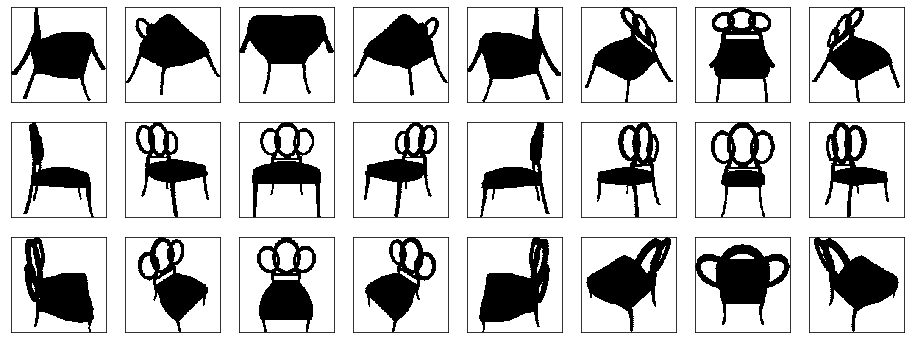

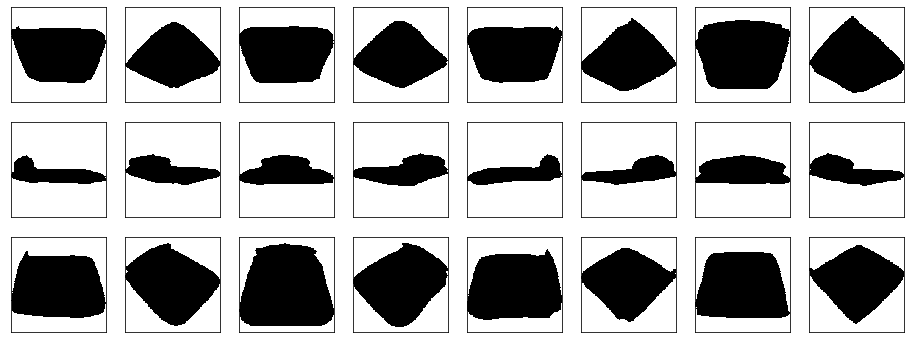

1.2692307233810425 40.0 148.13815307617188



{'2d_iou': 0, '2d_iou_multi': 0.46545768653353053, '3d_iou': 0, '3d_iou_norm': 0, 'chamfer_L1': 0, 'chamfer_L1_norm': 0}


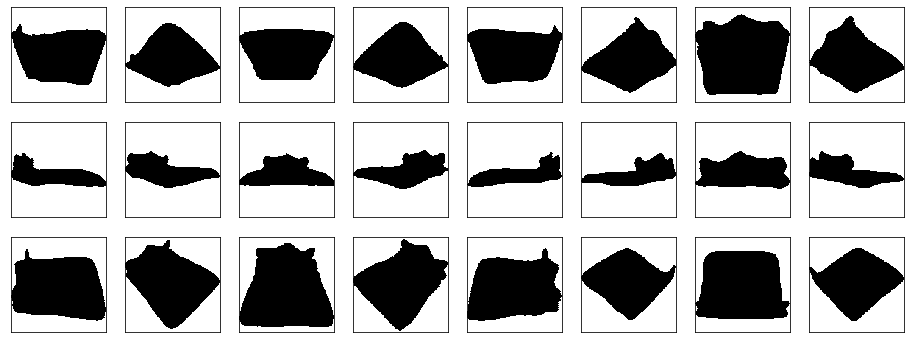

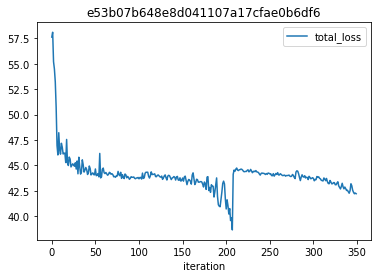

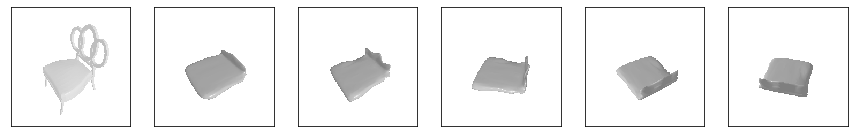

dae6ba7440a71e5152470de2774d6099
Input mesh metrics: {'2d_iou': 0, '2d_iou_multi': 0.40920300719638664, '3d_iou': 0, '3d_iou_norm': 0, 'chamfer_L1': 0, 'chamfer_L1_norm': 0}


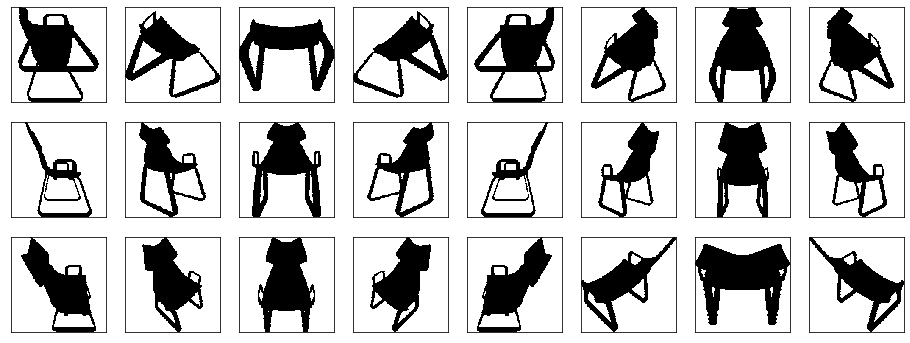

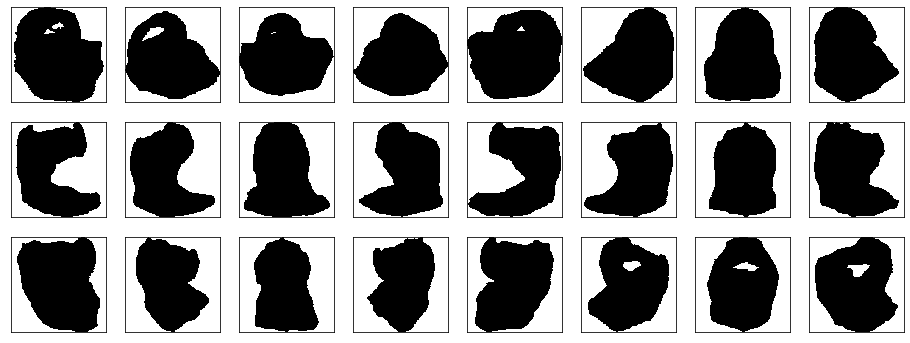

1.0128204822540283 40.0 81.22503662109375



{'2d_iou': 0, '2d_iou_multi': 0.4895424625525872, '3d_iou': 0, '3d_iou_norm': 0, 'chamfer_L1': 0, 'chamfer_L1_norm': 0}


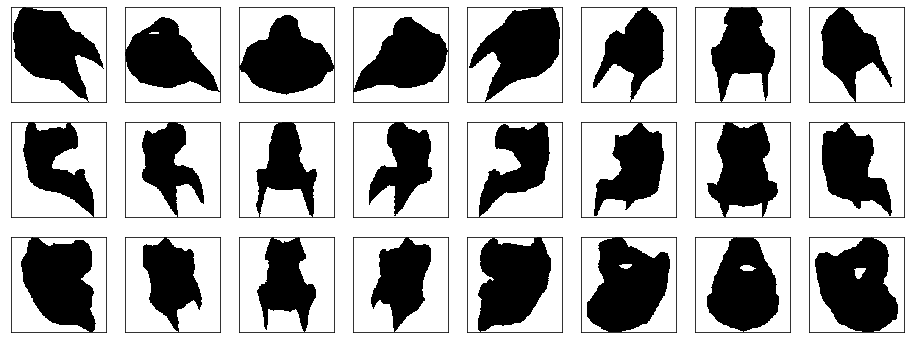

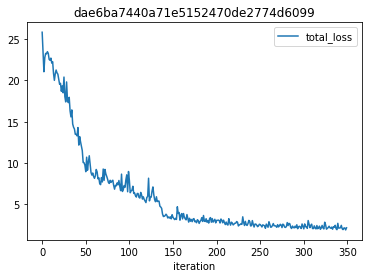

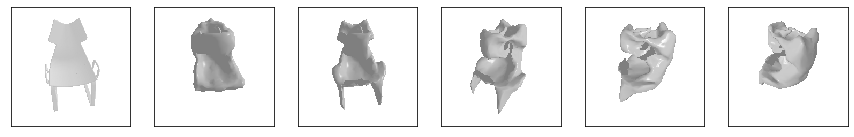

fdb00b6e3c3a8c6e9e7154e1e649e020
Input mesh metrics: {'2d_iou': 0, '2d_iou_multi': 0.763550008336703, '3d_iou': 0, '3d_iou_norm': 0, 'chamfer_L1': 0, 'chamfer_L1_norm': 0}


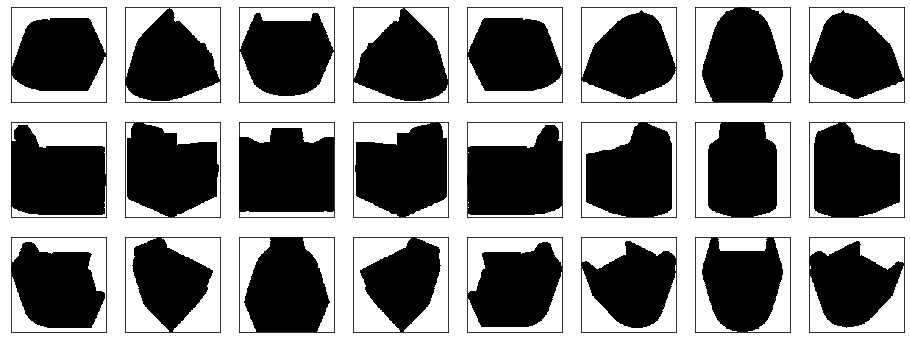

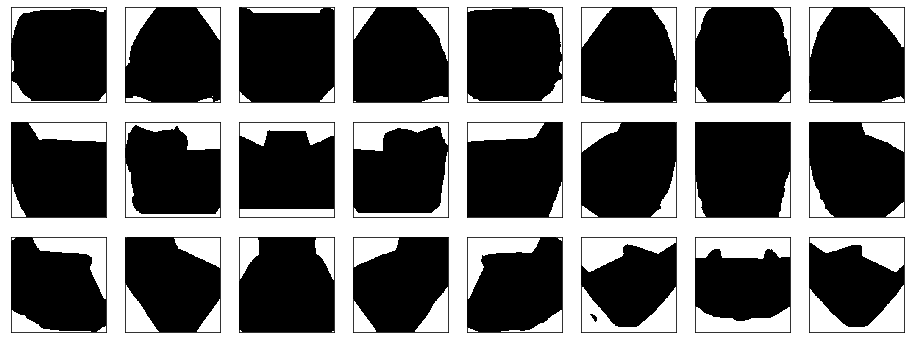

1.5897436141967773 40.0 31.62360954284668



{'2d_iou': 0, '2d_iou_multi': 0.7926480223735174, '3d_iou': 0, '3d_iou_norm': 0, 'chamfer_L1': 0, 'chamfer_L1_norm': 0}


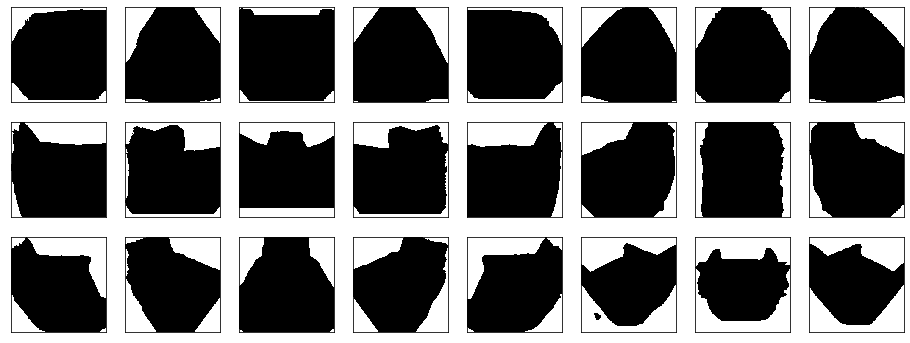

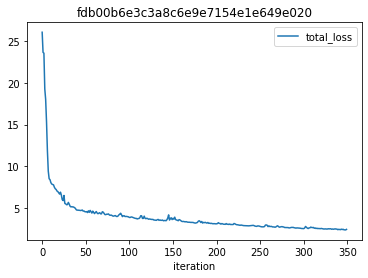

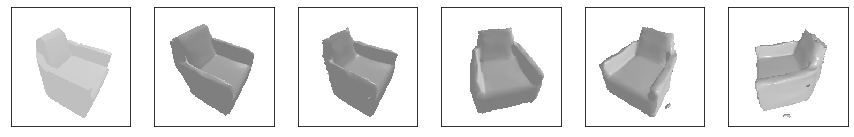

df8bb7ecc402ede384a05e54516915de
Input mesh metrics: {'2d_iou': 0, '2d_iou_multi': 0.35760119557380676, '3d_iou': 0, '3d_iou_norm': 0, 'chamfer_L1': 0, 'chamfer_L1_norm': 0}


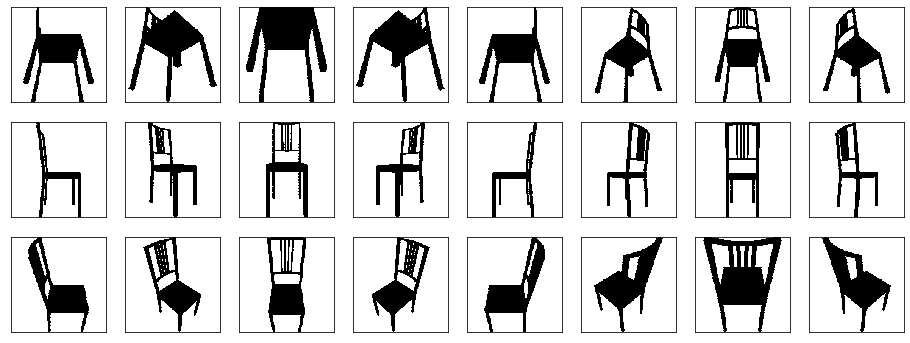

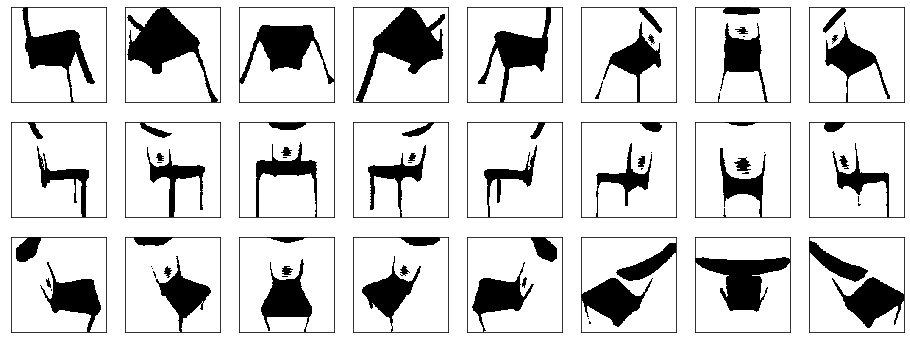

1.0769230127334595 40.0 264.0163269042969



{'2d_iou': 0, '2d_iou_multi': 0.39368835215767223, '3d_iou': 0, '3d_iou_norm': 0, 'chamfer_L1': 0, 'chamfer_L1_norm': 0}


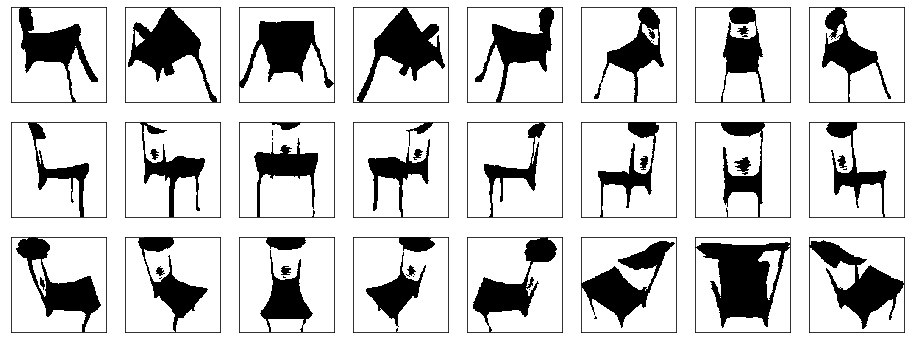

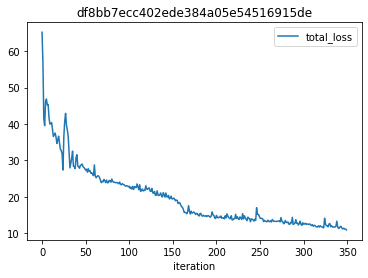

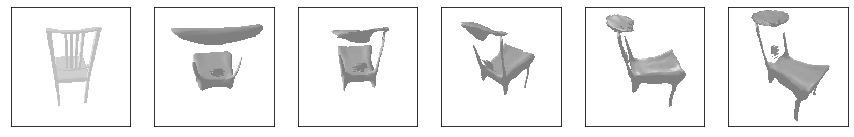

d9ce33c5f448815d7062f2d72cde5c95
Input mesh metrics: {'2d_iou': 0, '2d_iou_multi': 0.7901208698749542, '3d_iou': 0, '3d_iou_norm': 0, 'chamfer_L1': 0, 'chamfer_L1_norm': 0}


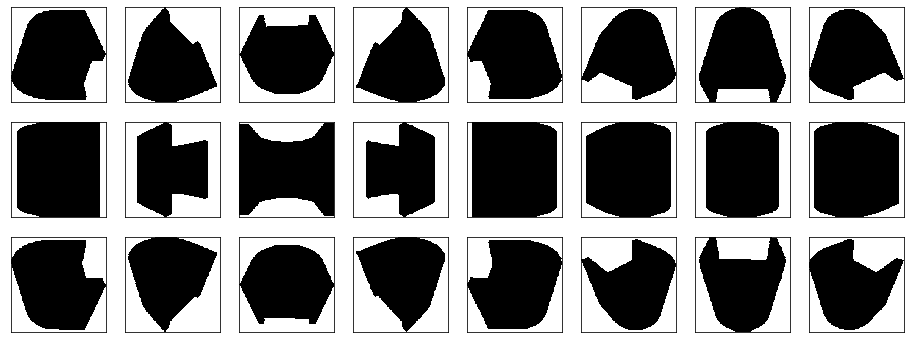

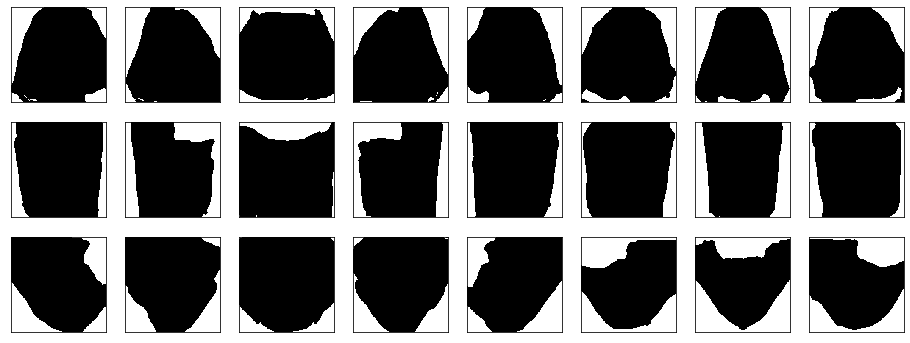

1.4615384340286255 40.0 249.8821258544922



{'2d_iou': 0, '2d_iou_multi': 0.7948382471998533, '3d_iou': 0, '3d_iou_norm': 0, 'chamfer_L1': 0, 'chamfer_L1_norm': 0}


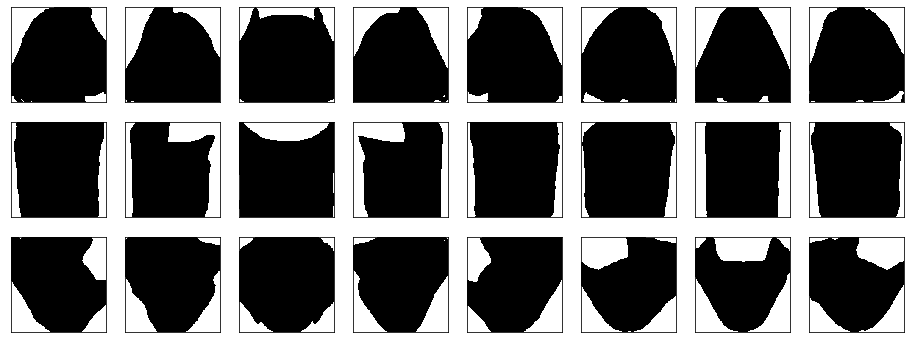

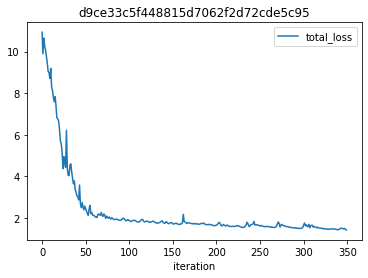

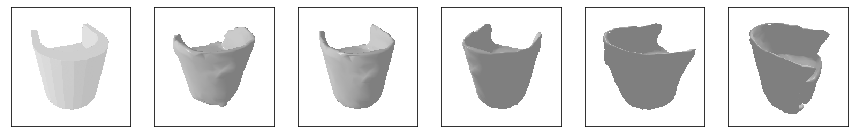

fcd8163b26250f499fe49e672436bc45


In [ ]:
num_azims=20
num_elevs=20
num_dists=40

results_df = pd.DataFrame()
for instance in instances:
    print(instance)
    input_img_path = os.path.join(input_img_dir,"{}.png".format(instance))
    input_image = np.asarray(Image.open(input_img_path))
    input_mesh_path = os.path.join(input_mesh_dir,"{}.obj".format(instance))
    gt_mesh_path = gt_shapes_dict[instance.split("_")[0]]
    with torch.no_grad():
        input_mesh = utils.load_untextured_mesh(input_mesh_path, device)
        gt_mesh = utils.load_untextured_mesh(gt_mesh_path, device)
    input_trimesh= trimesh.load(input_mesh_path)
    gt_trimesh = trimesh.load(gt_mesh_path)
    mask = np.asarray(input_image)[:,:,3] > 0
    
    #points = sample_points(gt_mesh.verts_packed(), 500000, 0.5)
    points=None
    instance_info = {"instance": instance}
    
    input_metrics_dict, input_debug_dict = eval_utils.eval_metrics(input_image, input_trimesh, input_mesh, gt_trimesh, gt_mesh, device, metrics_to_eval=["2d_iou_multi"], points=points)
    instance_info["original_2d_iou_multi"] = input_metrics_dict["2d_iou_multi"]
    print("Input mesh metrics: {}".format(input_metrics_dict))
    gt_masks, rec_masks, iou_2d_scores = input_debug_dict["2d_iou_multi"]
    visualization_tools.show_renders(gt_masks)
    visualization_tools.show_renders(rec_masks)
    
    
    # refining using gt pose
    #gt_dist = pose_dict[instance]["dist"]
    gt_elev = pose_dict[instance]["elev"]
    gt_azim = pose_dict[instance]["azim"]
    _, _, gt_dist, _, _ = brute_force_estimate_dist(input_mesh, mask, gt_azim, gt_elev, num_dists, device)
    bf_pred_azim, bf_pred_elev, bf_pred_dist, _, _ = brute_force_estimate_pose(input_mesh, mask, num_azims, num_elevs, num_dists, device)
    
    #for (dist, elev, azim, name) in [[gt_dist.item(), gt_elev, gt_azim, "gt"], [bf_pred_dist.item(), bf_pred_elev.item(), bf_pred_azim.item(), "bf"]]:
    for (dist, elev, azim, name) in [[bf_pred_dist.item(), bf_pred_elev.item(), bf_pred_azim.item(), "bf"]]:
    #for (dist, elev, azim, name) in [[gt_dist.item(), gt_elev, gt_azim, "gt"]]:
        print(dist, elev, azim)
        mesh_refiner = MeshRefiner(cfg, device)
        refined_mesh, loss_info = mesh_refiner.refine_mesh(input_mesh, input_image, dist, elev, azim)
        refined_mesh_path = os.path.join("notebooks/out", "{}_{}.obj".format(instance, name))
        save_obj(refined_mesh_path, refined_mesh.verts_packed(), refined_mesh.faces_packed())
        refined_trimesh = trimesh.load(refined_mesh_path)
        refined_mesh = utils.load_untextured_mesh(refined_mesh_path, device)
        refined_metrics, refined_debug_dict = eval_utils.eval_metrics(input_image, refined_trimesh, refined_mesh, gt_trimesh, gt_mesh, device, metrics_to_eval=["2d_iou_multi"], points=points)
        print(refined_metrics)
        instance_info["{}_refined_2d_iou_multi".format(name)] = refined_metrics["2d_iou_multi"]
        
        gt_masks, rec_masks, iou_2d_scores = refined_debug_dict["2d_iou_multi"]
        visualization_tools.show_renders(rec_masks)
        
        loss_info.plot.line(x='iteration', y='total_loss', title="{}".format(instance))
        visualization_tools.show_refinement_results(input_image, input_mesh, refined_mesh, dist, elev, azim, device)
    
    results_df = results_df.append(instance_info, ignore_index=True)
    print("=========================================================================================")


In [ ]:
#display(results_df)
#print(results_df.mean())